In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os
import sys
% matplotlib inline

In [2]:
#fname = '200625//200625_Bi2Ye30617_3w_1.txt'
fname = '210623//210623_Bi2Te3_p11_1mm_3w_1.txt'
df = pd.read_csv(fname, sep = ' ')


In [3]:
df.head()

,Date_time,Time,TC,SENS,Lockin1f,Lockin2f,X3,Y3,X3_ref,Y3_ref
2021-06-23,13:09:19.267001,1926.090166,15,21,0.0100,0.0091,-0.000872,0.000024,0.000168,-0.000005
2021-06-23,13:40:44.547833,3811.369998,15,21,0.0158,0.0157,-0.000881,0.000035,0.000163,-0.000007
2021-06-23,14:11:49.813520,5676.636685,15,21,0.0251,0.0250,-0.000876,0.000051,0.000163,-0.000010
2021-06-23,14:43:15.088351,7561.912517,15,21,0.0398,0.0397,-0.000875,0.000081,0.000161,-0.000016
2021-06-23,15:14:00.330893,9407.154059,15,21,0.0631,0.0631,-0.000862,0.000127,0.000159,-0.000023


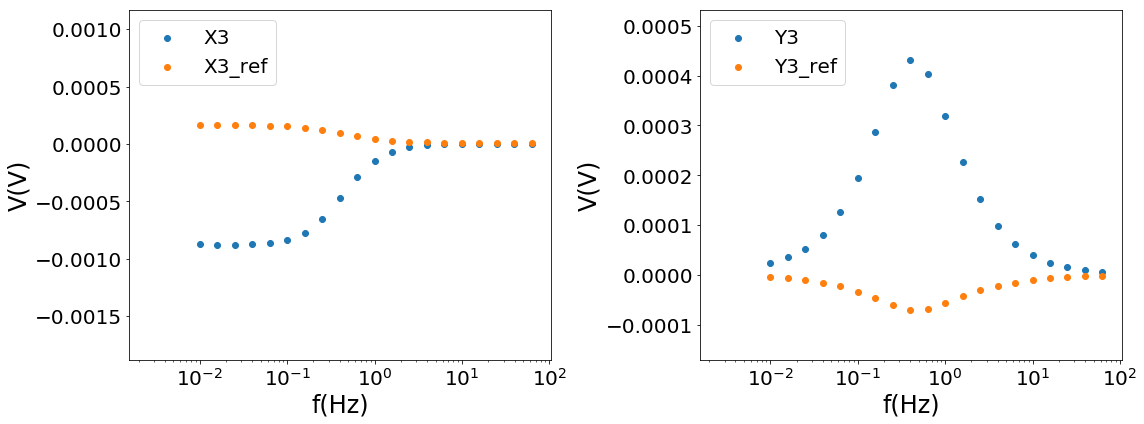

In [17]:
fig, axs = plt.subplots(1, 2, figsize = (16,6))
fz = 24

axs[0].scatter(df.Lockin1f, df.X3, label = 'X3')
axs[0].scatter(df.Lockin1f, df.X3_ref, label = 'X3_ref')
axs[0].set_xlabel('f(Hz)', fontsize = fz)
axs[0].set_ylabel('V(V)', fontsize = fz)
axs[0].set_xscale('log')
#axs[0].set_xlim(0.01,1000)
axs[0].legend(loc = 'upper left', fontsize = 20)
axs[0].tick_params(labelsize = 20)
#axs[0].set_ylim(df.X3.min() - 10e-6, df.X3.max() + 10e-6)
axs[0].set_ylim(min(df.X3_ref.min(),df.X3.min()) - 1000e-6, max(df.X3_ref.max(),df.X3.max()) + 1000e-6)
axs[1].scatter(df.Lockin1f, df.Y3, label = 'Y3')
axs[1].scatter(df.Lockin1f, df.Y3_ref, label = 'Y3_ref')
axs[1].set_xlabel('f(Hz)', fontsize = fz)
axs[1].set_ylabel('V(V)', fontsize = fz)
axs[1].set_xscale('log')
#axs[1].set_xlim(0.01,1000)
axs[1].tick_params(labelsize = 20)
axs[1].legend(loc = 'upper left', fontsize = 20)
axs[1].set_ylim(min(df.Y3_ref.min(),df.Y3.min()) - 100e-6, max(df.Y3_ref.max(),df.Y3.max()) + 100e-6)
#plt.subplots_adjust(hspace = 0.2,wspace = 0.2)
plt.tight_layout()
fig.savefig(fname[:-4] + '_raw.jpg', dpi = 100)

In [15]:
help(df.min)

Help on method min in module pandas.core.frame:

min(axis=None, skipna=None, level=None, numeric_only=None, **kwargs) method of pandas.core.frame.DataFrame instance
    This method returns the minimum of the values in the object.
                If you want the *index* of the minimum, use ``idxmin``. This is
                the equivalent of the ``numpy.ndarray`` method ``argmin``.
    
    Parameters
    ----------
    axis : {index (0), columns (1)}
    skipna : boolean, default True
        Exclude NA/null values. If an entire row/column is NA, the result
        will be NA
    level : int or level name, default None
        If the axis is a MultiIndex (hierarchical), count along a
        particular level, collapsing into a Series
    numeric_only : boolean, default None
        Include only float, int, boolean columns. If None, will attempt to use
        everything, then use only numeric data. Not implemented for Series.
    
    Returns
    -------
    min : Series or DataFrame 

In [63]:
alpha = 0.0069276#0.0048331#0.0048375 #0.0048331#temperature coefficient --need remeasure for better accuracy
Rref = 10.029#3.006829724
V_input = 0.7#1.1
X1 = 0.13939#0.0591204#0.0443347
X1_ref = 0.0741048#0.0572512#0.047478
I1w = X1_ref / Rref
Re0 = Rref * X1 / X1_ref #sample resistance at V_input = 1.1V

l = 8e-3/2 #4e-3/2#half length of wire(= half gap width)
width = 1.3e-3; #mm line width --
thickness = 80e-6#43.2375e-6#15.12e-6 #um line thickness --
S = width * thickness  #crosssectional area
rou =  7.74e3 #kg/m^3 density
#correction_factor = 1 - (Rref + Re0) / (50) # 1 - R_all_3w_parts / R_total

In [28]:
Re0

18.864396233442367

In [64]:
def X3_calc(f1, k, cp, correction_factor = 1):
    w1 = 2 * np.pi * f1
    kappa = k / (rou * cp)
    tau = 4 * l**2 / kappa
    X3 = - alpha * Re0**2 * I1w**3 * l / (12 * k * S) * (1 / (1 + (w1 * tau / 5)**2))
    return X3
def Y3_calc(f1, k, cp, correction_factor = 1):
    w1 = 2 * np.pi * f1
    kappa = k / (rou * cp)
    tau = 4 * l**2 / kappa
    Y3 = alpha * Re0**2 * I1w**3 * l / (12 * k * S) * ((w1 * tau / 5) / (1 + (w1 * tau / 5)**2))
    return Y3
def X3_Y3_fit(fcombo, k, cp):
    X3 = X3_calc(fcombo[:int(len(fcombo) / 2)], k, cp)
    Y3 = Y3_calc(fcombo[int(len(fcombo) / 2):], k, cp)
    return np.concatenate([X3,Y3])

In [65]:
xdata = np.concatenate([df['Lockin1f'], df['Lockin1f']])
ydata = np.concatenate([df['X3'], df['Y3']])
popt, pcov = curve_fit(X3_Y3_fit, xdata, ydata, p0 = [2, 100])

In [66]:
popt,pcov

(array([  3.62872401,  13.42063317]),
 array([[  2.57508470e-05,   2.38719131e-13],
        [  2.38719131e-13,   2.46777551e-03]]))

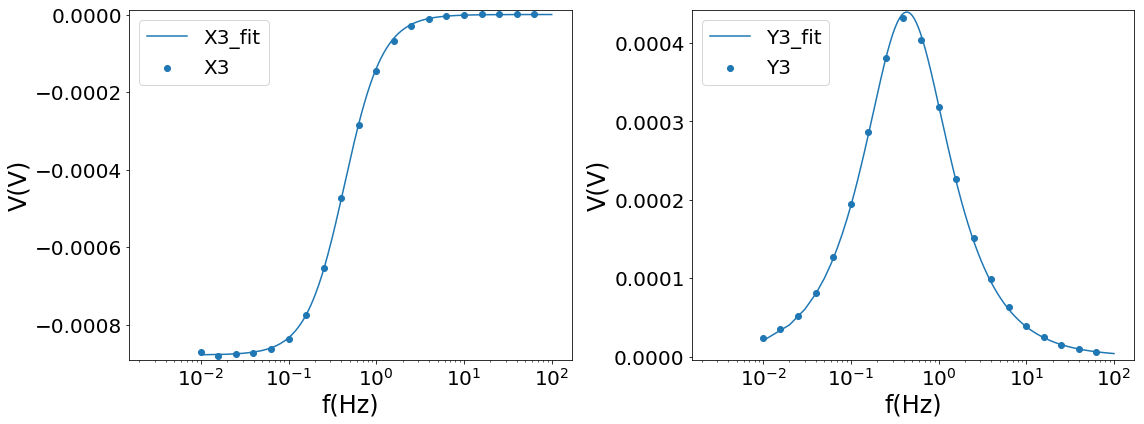

In [68]:
fig, axs = plt.subplots(1, 2, figsize = (16,6))
fz = 24

f1 = np.arange(0.01, 100.01, 0.01)

axs[0].scatter(df.Lockin1f, df.X3, label = 'X3')
#axs[0].scatter(df.Lockin1f, df.X3_ref, label = 'X3_ref')
#axs[0].scatter(df2.Lockin1f, df2.X3, label = 'X3 test2 (measured next day)')#
#axs[0].scatter(df2.Lockin1f, df2.X3_ref, label = 'X3_ref test2')
axs[0].plot(f1, X3_calc(f1,*popt), label = 'X3_fit')
axs[0].set_xlabel('f(Hz)', fontsize = fz)
axs[0].set_ylabel('V(V)', fontsize = fz)
axs[0].set_xscale('log')
#axs[0].set_xlim(0.01,1000)
axs[0].legend(loc = 'upper left', fontsize = 20)
axs[0].tick_params(labelsize = 20)
axs[0].set_ylim(df.X3.min() - 10e-6, df.X3.max() + 10e-6)

axs[1].scatter(df.Lockin1f, df.Y3, label = 'Y3')
#axs[1].scatter(df.Lockin1f, df.Y3_ref, label = 'Y3_ref')
#axs[1].scatter(df2.Lockin1f, df2.Y3, label = 'X3 test2')
#axs[1].scatter(df2.Lockin1f, df2.Y3_ref, label = 'X3_ref test2')
axs[1].plot(f1, Y3_calc(f1, *popt), label = 'Y3_fit')
axs[1].set_xlabel('f(Hz)', fontsize = fz)
axs[1].set_ylabel('V(V)', fontsize = fz)
axs[1].set_xscale('log')
#axs[1].set_xlim(0.01,1000)
axs[1].tick_params(labelsize = 20)
axs[1].legend(loc = 'upper left', fontsize = 20)
axs[1].set_ylim(df.Y3.min() - 10e-6, df.Y3.max() + 10e-6)
#axs[1].text(0.6,0.8, f"fitted k = {round(popt[0],2)} W/mK\nfitted cp = {round(popt[1],2)} J/kgK", 
#            fontsize = 14, transform=axs[1].transAxes)

#plt.subplots_adjust(hspace = 0.2,wspace = 0.2)
plt.tight_layout()
fig.savefig(fname[:-4] + '_fit.jpg', dpi = 300)

## help(plt.legend)